In [213]:
import re
import requests
import time
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
from pyecharts import *
from tabulate import tabulate #方便将 dataframe 生成表格显示。

## 1.爬取 Gank 中的所有数据。

### 1.1 获取所有 Gank 发布所有日期集合

In [362]:
import requests
history_date_url = 'http://gank.io/api/day/history'
history_res = requests.get(history_date_url)
history_date_list = history_res.json().get('results')

通过上面的代码共取得 651 条的数据（截止于 2018-12-27 ）。  
Gank 获取当天的数据的请求 API 为 [https://gank.io/api/day/2016/05/11](https://gank.io/api/day/2016/05/11)。   
而获取到的日期格式为 『2018-11-28』。所以我们转换一下日期转成『2016/05/11』格式。

### 1.2 开始爬取 Gank 所有的数据

将数据存放于 gank_data_list 中。

In [365]:
import re # 正则
import time
from tqdm import tqdm_notebook as tqdm #用于显示进度条

# 转换日期格式
history_date_list = [re.sub(r'(\d{4})-(\d{2})-(\d{2})',r'\1/\2/\3',date) for date in history_date_list] 
history_date_list
gank_data_list = []
for data in tqdm(history_dates):

    day_url = 'https://gank.io/api/day/' + data
    res = requests.get(day_url)
    if res.status_code == 200:
        try:
            categorys = res.json().get('category')
            result_datas = res.json().get('results')
            for category in categorys:
                data_list = result_datas.get(category)
                gank_data_list.extend(data_list)
            time.sleep(0.5)
        except (KeyError, TimeoutError):
            print("error:" + data)
            continue
  

共爬取了 9261 条数据(截止于 2018-12-27 )。

### 1.3 保存数据。  

将数据生成 DataFrame 并保存，以方便下次再使用。

In [ ]:
import pandas as pd
import numpy as np

# 保存数据到 gank.csv.
gank_df = pd.DataFrame(gank_data_list)
gank_df.to_csv( 'gank.csv', index=False,encoding='utf-8')

如果下次再使用则直接使用『gank.csv』中的数据即可。

In [1]:
import pandas as pd
import numpy as np
gank_df = pd.read_csv('gank.csv', engine='python',encoding='utf-8')
gank_df.head()

,_id,createdAt,desc,images,publishedAt,source,type,url,used,who,_date
0,5bfe119c9d2122309624cbab,2018-11-28 03:55:08.740,一个可插拔的Android应用程序，使用Lua脚本开发。,['https://ww1.sinaimg.cn/large/0073sXn7gy1fy58...,2018-12-13 00:00:00.000,chrome,App,https://github.com/hanks-zyh/hydrogenApp,True,lijinshanmx,2018-12-13
1,5bfe131d9d212230a505d140,2018-11-28 04:01:33.998,Beauty-Compass是在Android设备上运行的指南针的简单演示应用程序。,['https://ww1.sinaimg.cn/large/0073sXn7gy1fy58...,2018-12-13 00:00:00.000,chrome,App,https://github.com/arbelkilani/Beauty-Compass,True,lijinshanmx,2018-12-13
2,5c08ec729d212230a505d14f,2018-12-06 09:31:30.685,基于flutter的仿网易云音乐播放器,['https://ww1.sinaimg.cn/large/0073sXn7gy1fy58...,2018-12-13 00:00:00.000,web,App,https://github.com/boyan01/quiet-flutter,True,YangBin,2018-12-13
3,5bffb2249d2122309624cbbd,2018-11-29 09:32:20.813,定时任务执行状态监控,['https://ww1.sinaimg.cn/large/0073sXn7gy1fy58...,2018-12-13 00:00:00.000,web,瞎推荐,https://github.com/bruceye777/cronmon,True,bruceye777,2018-12-13
4,5c0ceab09d21223f5a2bae94,2018-12-13 08:05:44.786,一个快速的字节码编译插件，让你轻松修改Android项目中的任何字节码,NaN,2018-12-13 00:00:00.000,web,拓展资源,http://quinnchen.me/2018/09/13/2018-09-13-asm-...,True,Quinn,2018-12-13


## 2.处理并分析数据

首先我们简单查看一下数据的类型

In [28]:
gank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9261 entries, 0 to 9260
Data columns (total 11 columns):
_id            9261 non-null object
createdAt      9261 non-null datetime64[ns]
desc           9261 non-null object
images         2385 non-null object
publishedAt    9261 non-null datetime64[ns]
source         6262 non-null object
type           9261 non-null object
url            9261 non-null object
used           9261 non-null bool
who            8982 non-null object
_date          9261 non-null object
dtypes: bool(1), datetime64[ns](2), object(8)
memory usage: 732.6+ KB


其中列『createdAt』、『publishedAt』应该为 datetime 类型。所以得简单转换一下。  
『who』、『images』有缺失值，不过不影响我们的分析，所以不用管。

In [27]:
gank_df['createdAt'] = pd.to_datetime(gank_df['createdAt'])
gank_df['publishedAt'] = pd.to_datetime(gank_df['publishedAt'])

### 2.1  Gank 发布类型比例

先总的来看一下，Gank 发布类型的占比情况。

In [3]:
from pyecharts import *

gank_type_counts_ser = gank_df.type.value_counts()
type_pie = Pie("Gank 发布类型比例", "数据来源：gank.io", title_pos='center')
type_pie.add("占比", gank_type_counts_ser.index, gank_type_counts_ser.values, is_random=True,
              radius=[30, 75], rosetype='radius',
              is_legend_show=False, is_label_show=True)
type_pie.use_theme('dark')
# type_pie.render(path='Gank 发布类型比例.png') # 保存图  
type_pie

家家还是更喜欢 Android 一点。  

从 2015——2018 这个占比又有哪些变化 ？

In [29]:

timeline = Timeline(is_auto_play=True, timeline_bottom=0)
timeline.use_theme('dark')

gank_year_group = gank_df.groupby(pd.Grouper(key='publishedAt', freq='1Y'))
for name,group in gank_year_group:
    type_group_count_ser = group['type'].value_counts()
    type_group_pie = Pie("Gank 发布类型比例", "数据来源：gank.io", title_pos='center')
    type_group_pie.add("占比", type_group_count_ser.index, type_group_count_ser.values, is_random=True,
              radius=[30, 75], rosetype='radius',
              is_legend_show=False, is_label_show=True)
    timeline.add(type_group_pie,name.year)

# timeline.render(path='Gank 每年发布类型比例趋势.gif')    
timeline

移动端 iOS、Android 还是占大头。不过可以看出 2015 年时 iOS 的占比是比 Android 高的。

### 2.2 提交代码的人  

一共有多少人在 Gank 中提交过推荐呢。

In [368]:
len(gank_df['who'].unique())

854

可以看到一共有 854 人提交过代码。  

使用柱形图绘制 Gank 提交 Top20 的大佬。

In [346]:
gank_df['who'].isna().sum()

279

有 279 条数据提交的人没有留下名字。

In [24]:
who_counts_ser = gank_df['who'].value_counts()

who_bar = Bar("Gank 提交 Top20 的大佬", "来源：gank.io",width=1000, height=600)
who_bar.use_theme('vintage')
who_bar.add("提交次数", who_counts_ser.index[:20], who_counts_ser.values[:20],mark_point=['max'],
            xaxis_rotate = 30
        )
# who_bar.render(path='Gank 提交 Top20 的大佬.png') # 保存图  
who_bar

### 2.3 Gank 每次发布时的数量

有时候感觉 Gank 的更新好像不给力。所以我们来看一下其他的数据。

#### 2.3.1 每年发布的数量。


In [5]:
year_count_ser = gank_df.groupby(pd.Grouper(key='publishedAt', freq='1Y'))['_id'].count() # groupby each 1 年时间
year_count_bar = Bar("Gank 每年发布的数量", "来源：gank.io")
year_count_bar.add("发布数量", 
                   year_count_ser.index.strftime('%Y'), 
                   year_count_ser.values,
                   is_label_show=True
                    )
# year_count_bar.render('Gank 每年发布的数量.png')
year_count_bar

从数据上，数量先涨，先涨后降。  
但其实不是这样。Gank 是从 2015 年 5 月 18 日开始发布数据。
如果从 2015 初就开始的话，理论上的数量应该为 3611（计算在下面的代码中）。  

果然从 2015、2016 年之后，2017 年、2018 年移动端（Gank 的主要内容为移动端）热度下降了很多。

In [355]:
gank_df['publishedAt'].min()

Timestamp('2015-05-18 03:52:44.160000')

In [7]:
from datetime import datetime  

end_dt = datetime.strptime('2015-12-31', '%Y-%m-%d')
start_dt = datetime.strptime('2015-05-18', '%Y-%m-%d')
time_delta = (end_dt - start_dt).days
theory_nums = int(2246 * (365.0 / time_delta))
theory_nums

3611

#### 2.3.2 Gank 每次更新时发布的数量。

Gank 每次更新时，数量又有哪些不一样呢。

首先统计每次更新时的日期与数量，方法 1：

In [369]:
gank_every_counts_ser = gank_df.groupby(pd.Grouper(key='publishedAt', freq='D')).size() # 以天单位计算数量
gank_every_counts_ser = gank_every_counts_ser[gank_every_counts_ser > 0] # 取数量不为空的日期
gank_every_counts_ser.index = gank_every_counts_ser.index.strftime('%Y-%m-%d') # 将日期格式化为 index
gank_every_counts_ser.head()

2015-05-18    11
2015-05-19    12
2015-05-20    14
2015-05-21    17
2015-05-22    15
dtype: int64

方法 2：

In [8]:
gank_df['_date'] = gank_df['publishedAt'].map(lambda x : str(x)[:10]) # 生成一日期类，用于分组
gank_every_counts_ser = gank_df.groupby('_date').size() # # 使用日期分组，并统计数量
gank_every_counts_ser.head()

_date
2015-05-18    11
2015-05-19    12
2015-05-20    14
2015-05-21    17
2015-05-22    15
dtype: int64

In [9]:
gank_every_counts_line = Line("Gank 每次发送的数量", "来源：gank.io")
gank_every_counts_line.use_theme('vintage')
gank_every_counts_line.add('日期', 
                    gank_every_counts_ser.index, 
                    gank_every_counts_ser.values,
                    mark_point=['max'],               
                    is_datazoom_show=True  
                    )
# gank_every_counts_line.render('Gank 每次发送的数量.png')
gank_every_counts_line

好像每次发布数量越多，是因为断更时间更长导致。

### 2.4. 发布数量与断更时间的比较

数量为什么会有多有少呢，会不会与断更时间有关。  
断更时间长，堆的数量也就越多，下次更新时也就更多。 

首先得到发布的时间间隔字典 date_interval_dict

In [13]:
# 得到发布时间间隔。
gank_every_counts_ser_index = gank_every_counts_ser.index
# date_interval_dict 每次发布时间的间隔天数 dict.
date_interval_dict = { gank_every_counts_ser_index[0] : 0} # 第一项 为 0
for i in range(1, gank_every_counts_ser_index.shape[0]):
    day = (pd.to_datetime(gank_every_counts_ser_index[i]) - pd.to_datetime(gank_every_counts_ser_index[i-1])).days
    date_interval_dict[gank_every_counts_ser_index[i]] = day
date_interval_dict

{'2015-05-18': 0,
 '2015-05-19': 1,
 '2015-05-20': 1,
 '2015-05-21': 1,
 '2015-05-22': 1,
 '2015-05-25': 3,
 '2015-05-26': 1,
 '2015-05-27': 1,
 '2015-05-28': 1,
 '2015-05-29': 1,
 '2015-06-02': 4,
 '2015-06-03': 1,
 '2015-06-04': 1,
 '2015-06-05': 1,
 '2015-06-09': 4,
 '2015-06-10': 1,
 '2015-06-11': 1,
 '2015-06-12': 1,
 '2015-06-15': 3,
 '2015-06-16': 1,
 '2015-06-17': 1,
 '2015-06-18': 1,
 '2015-06-19': 1,
 '2015-06-26': 7,
 '2015-06-29': 3,
 '2015-06-30': 1,
 '2015-07-01': 1,
 '2015-07-02': 1,
 '2015-07-03': 1,
 '2015-07-07': 4,
 '2015-07-08': 1,
 '2015-07-09': 1,
 '2015-07-10': 1,
 '2015-07-13': 3,
 '2015-07-14': 1,
 '2015-07-15': 1,
 '2015-07-16': 1,
 '2015-07-17': 1,
 '2015-07-20': 3,
 '2015-07-21': 1,
 '2015-07-22': 1,
 '2015-07-23': 1,
 '2015-07-24': 1,
 '2015-07-27': 3,
 '2015-07-28': 1,
 '2015-07-29': 1,
 '2015-07-30': 1,
 '2015-07-31': 1,
 '2015-08-03': 3,
 '2015-08-05': 2,
 '2015-08-06': 1,
 '2015-08-07': 1,
 '2015-08-10': 3,
 '2015-08-11': 1,
 '2015-08-12': 1,
 '2015-08-

通过发送数量最多的 20 个做比较即可。

In [14]:
# 发布数量最大的日期 top2o
gank_every_ser_top20 = gank_every_counts_ser.sort_values(ascending=False)[:20]
# 通过上一项的数值得到当天离上一天的时间间隔
date_interval_value = [date_interval_dict[index] for index in gank_every_ser_top20.index]
gank_interval_line = Line("发布数量与断更时间的比较", "来源：gank.io")
gank_interval_line.use_theme('vintage')
gank_interval_line.add('发布数量', 
                    gank_every_ser_top20.index, 
                    gank_every_ser_top20.values,
                    mark_point=['max']        
                    )
gank_interval_line.add('间隔天数', 
                    gank_every_ser_top20.index, 
                    date_interval_value,
                    mark_point=['max']        
                    )
# gank_interval_line.render('发布数量与断更时间的比较.png')
gank_interval_line

从上图看出这两者之间好像并无关联。  
不过能不能换一个思路，不是断更时间越长，下一次发布的数量相对越多呢。

#### 2.3.4. 断更时间与发布数量的比较

In [15]:

date_interval_ser_top20 = pd.Series(date_interval_dict).sort_values(ascending=False)[:20] #得到时间间隔最大 top20

gank_interval_line2 = Line("断更时间与发布数量的比较", "来源：gank.io")
gank_interval_line2.use_theme('vintage')
gank_interval_line2.add('间隔天数', 
                    date_interval_ser_top20.index, 
                    date_interval_ser_top20.values,
                    mark_point=['max']        
                    )
# gank_interval_line2.add('数量平均数', 
#                     date_interval_ser_top20.index, 
#                     [int(gank_every_counts.mean()) for _ in range(20)] ,
#                     mark_point=['max']        
#                     )
gank_interval_line2.add('发布数量', 
                    date_interval_ser_top20.index, 
                    gank_every_counts_ser[date_interval_ser_top20.index],
                    is_label_show=True
                    )
# gank_interval_line2.render('断更时间与发布数量的比较.png')
gank_interval_line2

通过 gank_every_counts_ser.mean() 得到， 
每次发布的平均值为 14 条，由上图好像也看不出来断更时间与发布数量有必然的关系 。
所以说更断的原因，主要还是因为数量少。

#### 2.3.5  每年中，那几个月大家最活跃的呢。

In [16]:
year_month_line = Line("最活跃的月份", "来源：gank.io")
year_month_line.use_theme('shine')
year_group = gank_df.groupby(pd.Grouper(key='publishedAt', freq='1Y')) 
for name, group in year_group:
    year_mouth_count_ser = group.groupby(pd.Grouper(key='publishedAt', freq='1M'))['_id'].count()
    year_month_line.add(str(name.year), 
                    year_mouth_count_ser.index.strftime('%m').tolist(), 
                    year_mouth_count_ser.values.tolist(),
                    mark_point=['max'] )
# year_month_line.render('最活跃的月份.png')
year_month_line

3 月至 5 月最大家都活跃的时间

### 2.4 分享最多的网站 & 博客  

分类（Android，iOS, 前端）处理。

根据列 url 生成一个新列 domain。
然后使用 type 对数据分类统计。

In [19]:
import re
# 生成新列
def get_domain(url):
    domain = re.findall(r'http[s]?://(.*?)/.*?',url)
    if domain:
        return domain[0]
    else:
        return url
gank_df['domain'] = gank_df['url'].map(get_domain)
gank_df['domain'].head()

0      github.com
1      github.com
2      github.com
3      github.com
4    quinnchen.me
Name: domain, dtype: object

对 Android:

In [20]:
android_domain_ser = gank_df.groupby('type').get_group("Android")['domain'].value_counts()
android_domain_ser[android_domain_ser > 10]

github.com            2481
www.jianshu.com        182
mp.weixin.qq.com       126
blog.csdn.net          121
zhuanlan.zhihu.com      26
url.cn                  24
blog.mindorks.com       22
rkhcy.github.io         14
kymjs.com               13
Name: domain, dtype: int64

Android 分享中超过 10 次的网站分别: [Github](https://github.com/) 、[简书](https://www.jianshu.com/)、微信分享、[CSDN 博客](https://blog.csdn.net/)、[知乎专栏](https://zhuanlan.zhihu.com/)、[Mindroks](https://blog.mindorks.com/)、[HuYounger 的个人博客](http://rkhcy.github.io/)、[张涛开源实验室](https://kymjs.com/)。  

对 iOS:

In [21]:
iOS_domain_ser = gank_df.groupby('type').get_group("iOS")['domain'].value_counts()
iOS_domain_ser[iOS_domain_ser > 10]

github.com               1580
www.jianshu.com           185
swift.gg                   58
mp.weixin.qq.com           25
medium.com                 22
natashatherobot.com        22
www.imlifengfeng.com       21
christiantietze.de         20
yulingtianxia.com          19
realm.io                   17
www.raywenderlich.com      14
useyourloaf.com            13
segmentfault.com           12
Name: domain, dtype: int64

iOS 分享中超过 10 次的网站分别: [Github](https://github.com/) 、[简书](https://www.jianshu.com/)、[Swift 翻译组](http://swift.gg/)、微信分享、[Medium](https://medium.com/)、[Natasha The Robot](https://www.natashatherobot.com/)、 [christiantietze](https://christiantietze.de/)、[玉令天下的博客](http://yulingtianxia.com/)、[realm](https://realm.io/)、[raywenderlich](https://www.raywenderlich.com/)、[Use Your Loaf](https://useyourloaf.com/)、[SegmentFault](https://segmentfault.com/)。  

对前端：

In [22]:
前端_domain_ser = gank_df.groupby('type').get_group("前端")['domain'].value_counts()
前端_domain_ser[前端_domain_ser > 5]

github.com            304
zhuanlan.zhihu.com     79
www.jianshu.com        13
segmentfault.com        7
mp.weixin.qq.com        6
refined-x.com           6
Name: domain, dtype: int64

前端分享中超过 5 次的网站分别: [Github](https://github.com/) 、[知乎专栏](https://zhuanlan.zhihu.com/)、[简书](https://www.jianshu.com/)、[SegmentFault](https://segmentfault.com/)、微信分享、[雅X共赏的前端技术博客](http://refined-x.com/)。

## 3 生成词云

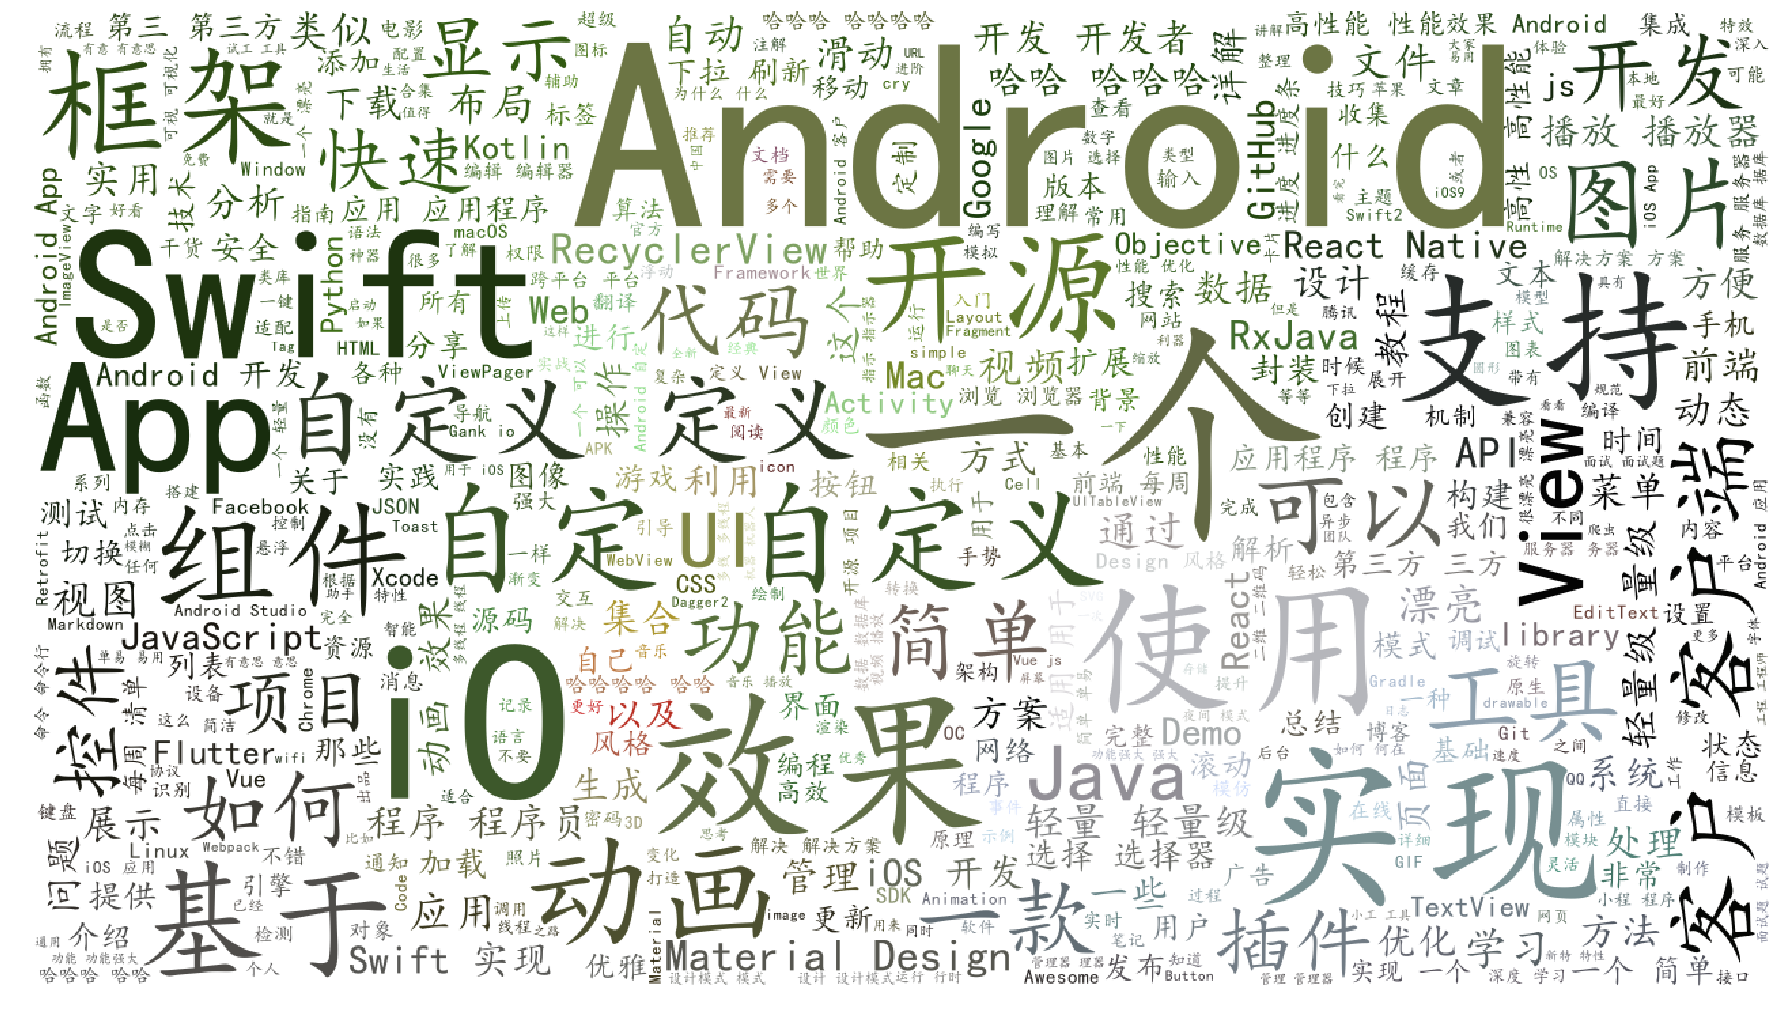

In [30]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import jieba
import pandas as pd
import numpy as np


gank_df = pd.read_csv('gank.csv', engine='python',encoding='utf-8')
# 过滤列 type为福利的项，取出列 desc 项中所有的值，将值转成 list
desc_dict = gank_df[gank_df['type'] != '福利']['desc'].tolist()
# 将 list 转成 str ，用于分词。
desc_texts = ' '.join(desc_dict)

# 分词
word_cut_list = jieba.cut(desc_texts, cut_all=True)
word_space_cut_split = ' '.join(word_cut_list)

# 
coloring = np.array(Image.open("gank_frog.jpg"))
my_wordcloud = WordCloud(background_color="white", 
                         width = 1280,
                         height = 720,
                         max_words=500,
                         mask=coloring, 
                         max_font_size=200, 
                         random_state=42, 
                         font_path=r'simkai.ttf' # 中文字体
                        ).generate(word_space_cut_split)
image_colors = ImageColorGenerator(coloring)
fig = plt.figure(figsize=(32,18))
image_colors = ImageColorGenerator(coloring)
plt.imshow(my_wordcloud.recolor(color_func=image_colors))
plt.imshow(my_wordcloud)
plt.axis("off")
plt.savefig('gank_word_cloud.png')
plt.show()

## 4 下载福利图

In [31]:
from multiprocessing.pool import ThreadPool
import requests
import os
import time
import pandas as pd
import numpy as np

gank_df = pd.read_csv('gank.csv', engine='python',encoding='utf-8')
girls_df = gank_df[gank_df['type']=='福利'][['publishedAt','url']]

downloads_url = [(str(row['publishedAt'])[:10],row['url']) for _ ,row in girls_df.iterrows()]


# 存放的文件夹
image_folder = '福利'
# 如果不存在则生成
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

def download_image(entry):
    path, uri = entry
    path = os.path.join(image_folder,f"{path}.jpg")
    if not os.path.exists(path):
        try:
            res = requests.get(uri, stream=True)
            if res.status_code == 200:
                with open(path, 'wb') as f:
                    f.write(res.content)
                time.sleep(2)
                #print(f'已下载:{path}')
        except Exception as e:
            print(f"请求出错: {path}")
    return path

# 开启多线程下载图片
results = ThreadPool(8).map(download_image, downloads_url)

已存在已存在已存在已存在已存在已存在已存在




已存在


已存在已存在
已存在已存在
已存在已存在
已存在
已存在已存在已存在





已存在已存在

